# 🔎 Related Queries Walkthrough — Meditation Trend Pulse

This notebook demonstrates how the **Related Queries page** of the app was built.

Like the other notebooks, this is a **static walkthrough** that:
- Loads the exact datasets used by the Streamlit page  
- Recreates the **tables and charts** for “Top”, “Rising”, and “Shared” related queries  
- Documents the **logic and design choices** behind each view

### Why this notebook matters
- Provides a **transparent, reproducible** record for review and hiring managers  
- Mirrors the app’s insights without needing to run the live dashboard  
- Keeps the style **consistent** with the Global & Country notebooks

### Contents
1. ⭐ Top Related Queries (by keyword)  
2. 📈 Rising Related Queries (momentum)  
3. 🤝 Shared Related Queries (overlap across keywords)

In [1]:
# ──────────────────────────────────────────────
# 📦 Setup — Related Queries Trends Walkthrough Notebook
# ──────────────────────────────────────────────

import os                   # File and directory operations
import pandas as pd         # Data manipulation and analysis
import matplotlib.pyplot as plt  # plotting library for static charts
from pytrends.request import TrendReq  # Google Trends API wrapper

# Configure pandas display for cleaner outputs
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)
pd.set_option("display.float_format", "{:,.2f}".format)

## 📡 Initialize Pytrends Client

This cell sets up the Google Trends client and defines the core keyword set used for the **Related Queries Trends page**.

### What this does
- Creates a `pytrends` client for querying Google Trends  
- Fixes the timezone (UTC−6) so weekly bins align consistently  
- Declares the five keywords tracked across the dashboard  

### Parameters
- `hl="en-US"` → results in English  
- `tz=360` → timezone offset in minutes (UTC−6)  
- `timeout=(15, 45)` → connection/read timeouts for stability  

### Keywords Tracked
- meditation  
- mindfulness  
- breathwork  
- guided meditation  
- yoga nidra  

In [2]:
# ──────────────────────────────────────────────
# 📡 Initialize Pytrends Client
# ──────────────────────────────────────────────

# Initialize Google Trends client with clear defaults
pytrends = TrendReq(
    hl="en-US",        # Interface language
    tz=360,            # Timezone offset in minutes (UTC−6 → weekly bins align well)
    timeout=(15, 45),  # (connect timeout, read timeout) in seconds
)

# Core set of tracked keywords — consistent across all Trend Pulse pages
KEYWORDS = [
    "meditation",
    "mindfulness",
    "breathwork",
    "guided meditation",
    "yoga nidra",
]

### 📥 Pulling and Reshaping Google Trends Data

To begin, we use **Pytrends** to fetch **Top** and **Rising** related queries for all five keywords in a single request.  
By default, Google Trends returns separate tables per keyword and per type (**Top** vs **Rising**).

For analysis and visualization, we reshape this into a **long format**:  
- Each row now represents a `(keyword, query, value, kind, rank)` record  
- This structure is easier to compare across keywords and summarize by query  
- It also matches the tidy data principles that power our Streamlit app  

This section outputs the normalized long-format tables for both **Top** and **Rising** to clearly show the transformation.

In [3]:
# ──────────────────────────────────────────────
# ⭐ Pull & Prepare “Top Related” Queries for All Keywords
# ──────────────────────────────────────────────

frames = []  # accumulate one df per keyword

# Query Top Related for each keyword separately
for kw in KEYWORDS:
    pytrends.build_payload([kw], timeframe="today 5-y", geo="")  # 5-year window, worldwide
    related = pytrends.related_queries().get(kw, {})             # dict: {"top": df, "rising": df}
    df_block = related.get("top")

    if df_block is None or df_block.empty:
        continue  # skip if no data returned for this keyword

    # Normalize into tidy rows: (keyword, related_query, popularity_score)
    df_kw = (
        df_block.reset_index(drop=True)
                .rename(columns={"query": "related_query", "value": "popularity_score"})
                .assign(keyword=kw)
                .loc[:, ["keyword", "related_query", "popularity_score"]]
    )
    frames.append(df_kw)

# Combine across keywords
df_top = (
    pd.concat(frames, ignore_index=True)
      .dropna(subset=["related_query"])
      .sort_values(["keyword", "popularity_score"], ascending=[True, False])
      .reset_index(drop=True)
)

# Preview top-5 rows per keyword
display(
    df_top.groupby("keyword", as_index=False, group_keys=False)
          .head(5)
          .reset_index(drop=True)
)

,keyword,related_query,popularity_score
0,breathwork,holotropic breathwork,100
1,breathwork,breathwork training,63
2,breathwork,breathwork meditation,44
3,breathwork,what is breathwork,41
4,breathwork,breathwork near me,34
...,...,...,...
20,yoga nidra,yoga nidra sleep,100
21,yoga nidra,nidra yoga youtube,82
22,yoga nidra,meditation,64
23,yoga nidra,yoga nidra meditation,63


### 📊 Visual: Top Related Queries — Single Keyword

Select a keyword below (by editing the variable) to view its **Top 10 related queries** as a horizontal bar chart.  
This mirrors the behavior of the Streamlit table but as a static figure for review.

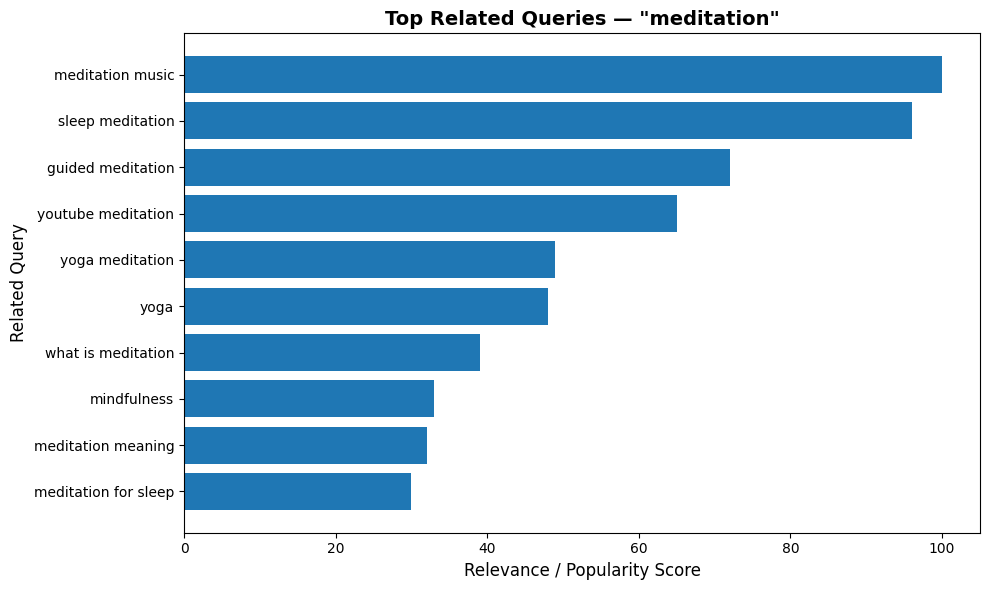

In [4]:
# ──────────────────────────────────────────────
# 📊 Plot: Top 10 related queries for one keyword
# ──────────────────────────────────────────────
SELECT_KEYWORD = "meditation"  # ← change to any of your tracked keywords

subset = (
    df_top[df_top["keyword"].str.lower() == SELECT_KEYWORD.lower()]
    .sort_values("popularity_score", ascending=True)
    .tail(10)
)

plt.figure(figsize=(10, 6))
plt.barh(subset["related_query"], subset["popularity_score"])
plt.title(f'Top Related Queries — "{SELECT_KEYWORD}"', fontsize=14, weight="bold")
plt.xlabel("Relevance / Popularity Score", fontsize=12)
plt.ylabel("Related Query", fontsize=12)
plt.tight_layout()
plt.show()

### 📈 Rising Related Queries (momentum)

Rising queries capture **surging interest**—terms growing fastest relative to their recent baseline.  
These often reflect **emerging topics, formats, or influencers**.

In [5]:
# ──────────────────────────────────────────────
# 📈 Pull & Prepare “Rising Related” Queries for All Keywords
# ──────────────────────────────────────────────

frames = []  # accumulate one df per keyword

# Query Rising Related for each keyword separately
for kw in KEYWORDS:
    pytrends.build_payload([kw], timeframe="today 5-y", geo="")  # 5-year window, worldwide
    related = pytrends.related_queries().get(kw, {})             # dict: {"top": df, "rising": df}
    df_block = related.get("rising")

    if df_block is None or df_block.empty:
        continue  # skip if no data returned for this keyword

    # Normalize into tidy rows: (keyword, related_query, popularity_score)
    df_kw = (
        df_block.reset_index(drop=True)
                .rename(columns={
                    "query": "related_query",
                    "value": "popularity_score",   # pytrends uses 'value' for rising score
                    "score": "popularity_score",   # tolerate alt naming if present
                    "growth_score": "popularity_score"
                })
                .assign(keyword=kw)
                .loc[:, ["keyword", "related_query", "popularity_score"]]
    )
    frames.append(df_kw)

# Combine across keywords
df_rising = (
    pd.concat(frames, ignore_index=True)
      .dropna(subset=["related_query"])
      .sort_values(["keyword", "popularity_score"], ascending=[True, False])
      .reset_index(drop=True)
)

# Preview top-5 rows per keyword
display(
    df_rising.groupby("keyword", as_index=False, group_keys=False)
             .head(5)
             .reset_index(drop=True)
)

,keyword,related_query,popularity_score
0,breathwork,9d breathwork,142900
1,breathwork,owaken breathwork,34150
2,breathwork,witality breathwork,31050
3,breathwork,gary brecka breathwork,30450
4,breathwork,somatic release breathwork,30000
...,...,...,...
20,yoga nidra,yoga nidra ally boothroyd,138900
21,yoga nidra,yoga nidra nsdr,69400
22,yoga nidra,nsdr,69400
23,yoga nidra,anabel otero yoga nidra,29800


### 📊 Visual: Rising Related Queries — Single Keyword

Change the keyword selector to explore the **Top 10 rising queries** for that topic.

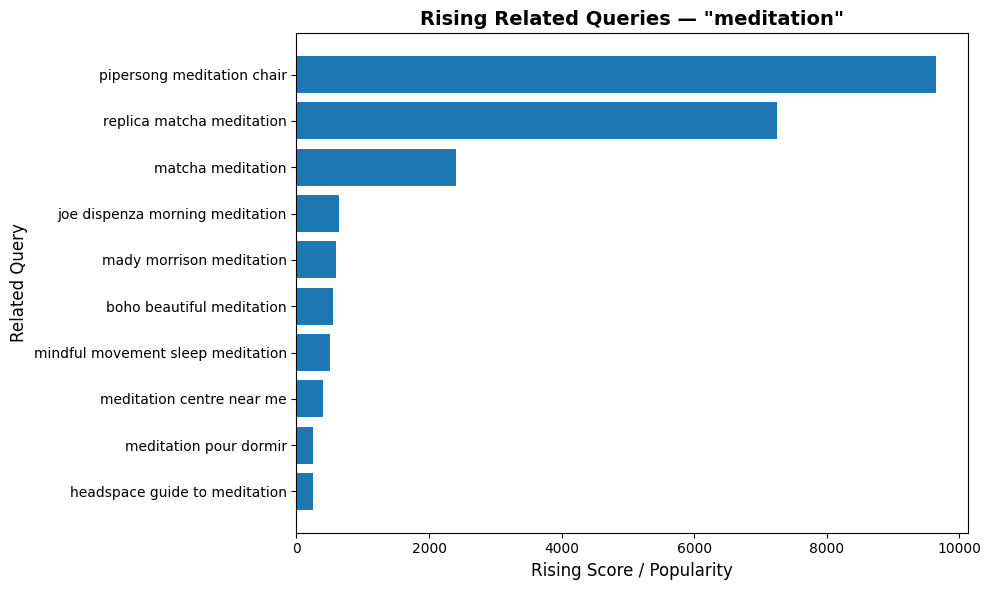

In [6]:
# ──────────────────────────────────────────────
# 📊 Plot: Top 10 rising related queries
# ──────────────────────────────────────────────
SELECT_KEYWORD_RISING = "meditation"  # ← change as desired

subset_r = (
    df_rising[df_rising["keyword"].str.lower() == SELECT_KEYWORD_RISING.lower()]
    .sort_values("popularity_score", ascending=True)
    .tail(10)
)

plt.figure(figsize=(10, 6))
plt.barh(subset_r["related_query"], subset_r["popularity_score"])
plt.title(f'Rising Related Queries — "{SELECT_KEYWORD_RISING}"', fontsize=14, weight="bold")
plt.xlabel("Rising Score / Popularity", fontsize=12)
plt.ylabel("Related Query", fontsize=12)
plt.tight_layout()
plt.show()

### 🤝 Shared Related Queries (overlap across keywords)

This section surfaces queries that **appear for multiple primary keywords**, revealing **common user intents**.  
It’s useful for spotting **bridge topics** (e.g., breathwork ↔ meditation) that connect different audiences.

In [7]:
# ──────────────────────────────────────────────
# 🤝 Build “Most-Shared” Related Queries table
# ──────────────────────────────────────────────

# Base: combine Top + Rising (keyword, related_query), drop dupes per (keyword, query)
shared_base = (
    pd.concat([
        df_top.loc[:, ["keyword", "related_query"]],
        df_rising.loc[:, ["keyword", "related_query"]],
    ], ignore_index=True)
    .dropna(subset=["related_query"])
    .drop_duplicates()
    .assign(
        keyword=lambda d: d["keyword"].astype(str).str.strip(),
        related_query=lambda d: d["related_query"].astype(str).str.strip(),
    )
)

# Count how many DISTINCT keywords each related_query appears under
df_shared_counts = (
    shared_base.groupby("related_query")["keyword"]
               .nunique()
               .reset_index(name="keyword_count")
               .sort_values(["keyword_count", "related_query"], ascending=[False, True])
               .reset_index(drop=True)
)

# (Optional) Keep only queries that appear for ≥ 2 keywords:
# df_shared_counts = df_shared_counts.query("keyword_count >= 2").reset_index(drop=True)

# Show the most “universal” related queries
df_shared_counts.head(20)

,related_query,keyword_count
0,mindfulness meditation,3
1,meditation,2
2,meditation for anxiety,2
3,meditation for sleep,2
4,meditation music,2
...,...,...
15,anabel otero yoga nidra,1
16,andrew huberman,1
17,andrew huberman yoga nidra,1
18,best breathwork app,1


### 🤝 Visual: Most‑Shared Related Queries

This bar chart highlights related queries that **appear under multiple primary keywords**.  
Higher bars indicate **broader relevance** across topics, helping you spot **bridge intents** (e.g., breathwork ↔ meditation).  
The view shows the top N (default **15**) and is sorted so the **most universally shared** queries appear at the top.

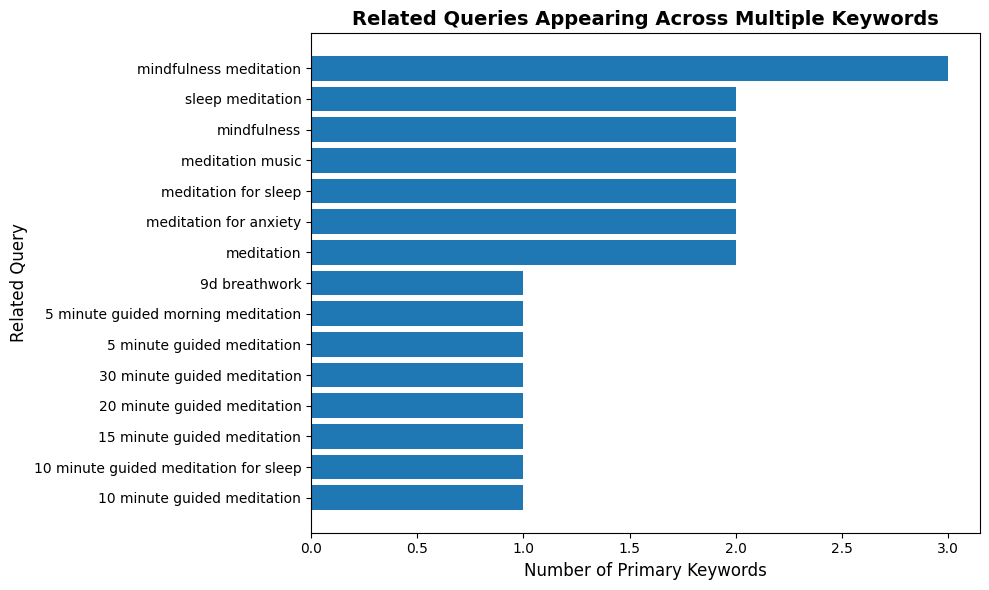

In [8]:
# ──────────────────────────────────────────────
# 📊 Plot: Most-Shared Related Queries
# ──────────────────────────────────────────────
top_n = 15
plot_df = df_shared_counts.head(top_n).sort_values("keyword_count", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(plot_df["related_query"], plot_df["keyword_count"])
plt.title("Related Queries Appearing Across Multiple Keywords", fontsize=14, weight="bold")
plt.xlabel("Number of Primary Keywords", fontsize=12)
plt.ylabel("Related Query", fontsize=12)
plt.tight_layout()
plt.show()

## ✅ Conclusion — Related Queries Walkthrough

In this notebook, we reconstructed the **Related Queries page** with static, reproducible views.

### What we demonstrated
- ⭐ **Top Related** — most common co‑searches per keyword  
- 📈 **Rising Related** — fast‑growing query ideas signaling momentum  
- 🤝 **Shared Related** — overlap that reveals bridge intents across topics  

### Why this matters
These views explain **how people expand or refine** their meditation‑adjacent searches, helping stakeholders see **adjacencies, emerging trends, and common threads** behind the dashboard’s insights.